# Industry. Temperature Prediction in Steel Melting

In order to optimize production costs, the smelter decided to reduce electricity consumption during the steel processing stage. You have to build a model that predicts the temperature of the steel.

## Description of the processing step

Steel is processed in a metal ladle with a capacity of about 100 tons. In order for the ladle to withstand high temperatures, it is lined with refractory bricks from the inside. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the lid of the bucket.

Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding impurities, and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of alloy from a bunker for bulk materials or wire through a special tribe apparatus.

Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are reached.

Then the molten steel is sent to finish the metal or enters the continuous casting machine. From there, the finished product comes out in the form of slab blanks.

### Data Description

The data consists of files obtained from different sources:

- `data_arc.csv` — electrode data;
- `data_bulk.csv` - data on the supply of bulk materials (volume);
- `data_bulk_time.csv` - data on the supply of bulk materials (time);
- `data_gas.csv` — data on alloy gas purge;
- `data_temp.csv` - temperature measurement results;
- `data_wire.csv` - data on wire materials (volume);
- `data_wire_time.csv` - data on wire materials (time).

In all files, the `key` column contains the batch number. Files can have multiple lines with the same `key` value: they correspond to different processing iterations.

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load datasets
try:
    df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")

## Data preparation

At this stage, we will study general information about datasets.

### Electrode Data

These graphite electrodes heat the steel to the desired temperature.

In [3]:
df_arc.sample(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
656,142,2019-05-08 16:41:46,2019-05-08 16:43:37,0.462461,0.330141
7256,1575,2019-06-29 03:01:15,2019-06-29 03:02:41,0.337043,0.255709
13007,2828,2019-08-18 01:15:52,2019-08-18 01:18:56,0.789564,0.500891
13292,2893,2019-08-20 08:43:20,2019-08-20 08:44:14,0.212033,0.145487
14131,3072,2019-08-26 18:07:45,2019-08-26 18:09:49,0.482527,0.295017


In [4]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


This dataset has 5 columns and 14,876 rows. There are no passes. The columns "Start of arc heating" and "End of arc heating" must be cast to the datetime type.

In [5]:
#change data type to datetime
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
#and check that the data type has been successfully changed
df_arc.dtypes

key                              int64
Начало нагрева дугой    datetime64[ns]
Конец нагрева дугой     datetime64[ns]
Активная мощность              float64
Реактивная мощность            float64
dtype: object

In [6]:
#check the dataset for duplicates
print('Number of duplicates in df_arc dataset:', df_arc.duplicated().sum())

Number of duplicates in df_arc dataset: 0


In [7]:
#see descriptive statistics
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


There is a clear spike in reactive power equal to -715.504924.

<AxesSubplot:xlabel='Реактивная мощность'>

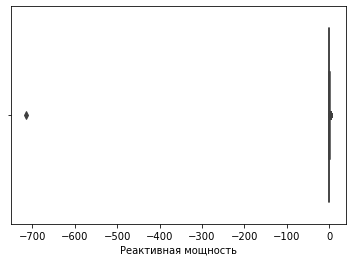

In [8]:
#look at the boxplot to confirm it's an outlier
sns.boxplot(df_arc['Реактивная мощность'])

Yes, this is a clear outlier and needs to be eliminated.

In [9]:
df_arc[df_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [10]:
#check that this line is not the last one in the batch
df_arc[df_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [11]:
#only one position, can be deleted
df_arc = df_arc[df_arc['Реактивная мощность'] >= 0]

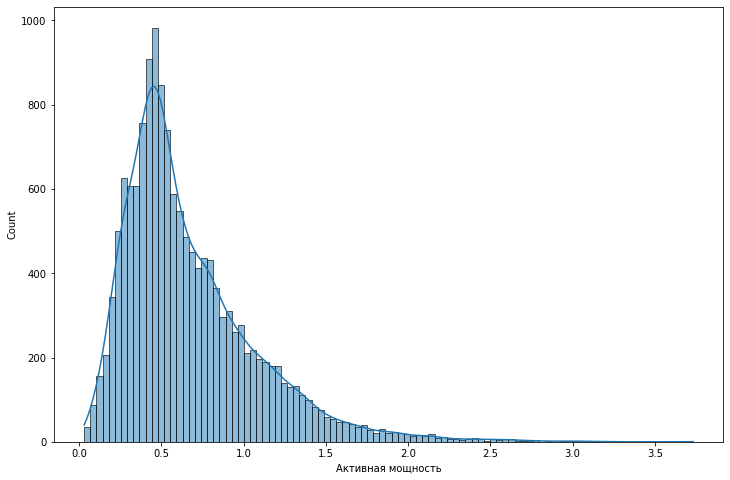

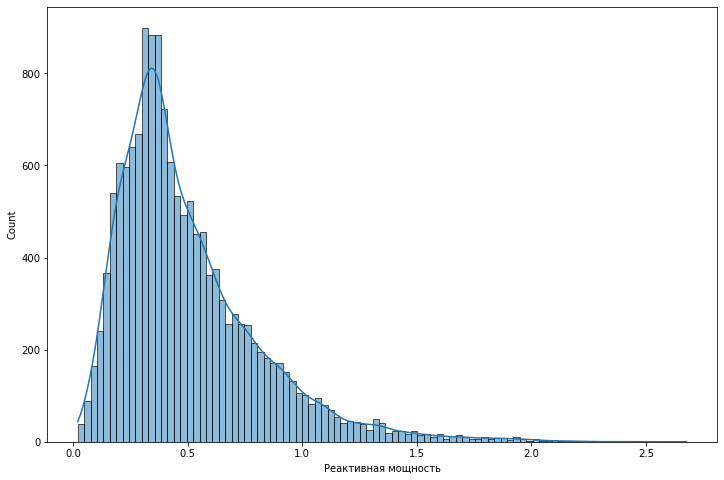

In [12]:
#consider the distribution density
plt.figure(figsize=(12,8))
sns.histplot(df_arc['Активная мощность'], kde=True)
plt.show()

plt.figure(figsize=(12,8))
sns.histplot(df_arc['Реактивная мощность'], kde=True)
plt.show()

In general, the distribution is normal, skewed to the right.

#### The result of the dataset with data on the electrodes.
1. The dataset has 14,876 rows and 5 columns.
2. There are no passes or duplicates.
3. Columns `Arc heating start` and `Arc heating end` have been changed to `datetime` type.
4. One outlier has been removed.

### Bulk materials feeding data (volume and time)

Bulk materials are used to alloy steel and change the chemical composition of the alloy.

In [13]:
df_bulk.sample(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
513,542,NaN,NaN,NaN,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227.0,NaN,140.0,224.0
2209,2289,NaN,NaN,186.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,395.0,NaN,128.0,227.0
2227,2307,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,204.0,NaN,99.0,104.0
443,469,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,106.0,NaN,207.0,NaN,254.0,204.0
1323,1375,NaN,NaN,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,190.0,106.0


In [14]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [15]:
print('The number of duplicates in the df_bulk dataset:', df_bulk.duplicated().sum())

The number of duplicates in the df_bulk dataset: 0


In [16]:
df_bulk_time.sample(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
274,292,NaN,NaN,NaN,2019-05-14 07:57:59,NaN,NaN,NaN,NaN,NaN,2019-05-14 07:57:59,NaN,2019-05-14 07:47:20,NaN,2019-05-14 07:47:20,2019-05-14 07:47:20
3049,3158,NaN,NaN,2019-08-29 08:08:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-29 08:04:03,NaN,2019-08-29 08:04:03,NaN
1163,1211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-16 03:54:45,NaN,2019-06-16 03:54:45,2019-06-16 03:54:45
1127,1175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-15 00:01:00,NaN,2019-06-15 00:01:00,2019-06-15 00:01:00
2729,2832,NaN,NaN,2019-08-18 04:50:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-18 04:43:11,NaN,2019-08-18 04:43:11,2019-08-18 04:43:11


In [17]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [18]:
print('Number of duplicates in df_bulk_time dataset:', df_bulk_time.duplicated().sum())

Number of duplicates in df_bulk_time dataset: 0


The presented datasets have 3129 rows and 16 columns. There are no duplicates. Data in all columns except 'key' of type object. There are a lot of gaps and I attribute this to the fact that these impurities were not added to every alloy and not every time, but only if necessary to change the composition. The number of gaps and filled values for each column in both tables are the same. I don’t see much point in further analysis of these datasets, because due to the variability in the use of these materials, there will be many outliers and anomalies.

### Wire materials data (volume and time)

Next, consider datasets with wire materials, because they are also used for alloying steel.

In [19]:
df_wire.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2946,3105,104.176804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,353,63.367203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1802,1892,104.972397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2874,3027,70.019043,15.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2776,2929,107.059677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [21]:
print('Number of duplicates in df_wire dataset:', df_wire.duplicated().sum())

Number of duplicates in df_wire dataset: 0


In [22]:
df_wire_time.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
463,495,2019-05-21 19:16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1185,1253,2019-06-17 17:05:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2675,2816,2019-08-17 16:09:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,255,2019-05-12 22:36:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1749,1839,2019-07-07 18:14:50,2019-07-07 18:20:06,2019-07-07 18:33:17,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [24]:
print('Number of duplicates in df_wire_time dataset:', df_wire_time.duplicated().sum())

Number of duplicates in df_wire_time dataset: 0


These datasets have 3081 rows and 10 columns. There are no duplicates. Data in all columns except 'key' of type object.

Here we see exactly the same picture as in the previous datasets: there are a lot of gaps, the number of gaps in each column of both datasets is the same, Wire 5 was used only once, but Wire 1 was used in 99% of cases.

### Alloy gas purge data

The gas is used to purge the alloy after addition of alloying materials.

In [25]:
df_gas.sample(5)

,key,Газ 1
720,723,10.321414
2604,2607,5.088828
2082,2085,3.908491
628,631,7.950360
3221,3224,8.640841


In [26]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [27]:
print('Number of duplicates in df_gas dataset:', df_gas.duplicated().sum())

Number of duplicates in df_gas dataset: 0


This dataset has 3239 rows and only 2 columns. There are no gaps or duplicates.

In [28]:
#look at descriptive statistics
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


The maximum value of 77.99 looks like an outlier. Let's build a boxplot.

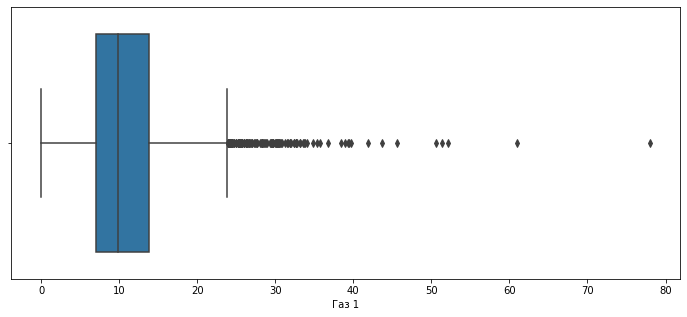

In [29]:
plt.figure(figsize=(12,5))
sns.boxplot(df_gas['Газ 1'])
plt.show()

Judging by the boxplot, explicit outliers start after 40. Let's calculate the exact value of the start of outliers using the formula: q_3 (3rd quartile) + 3 * irq (interquartile range). It turns out that 13.76 + 3*(13.76 - 7.04) = 33.92 and all values from 34 are outliers.

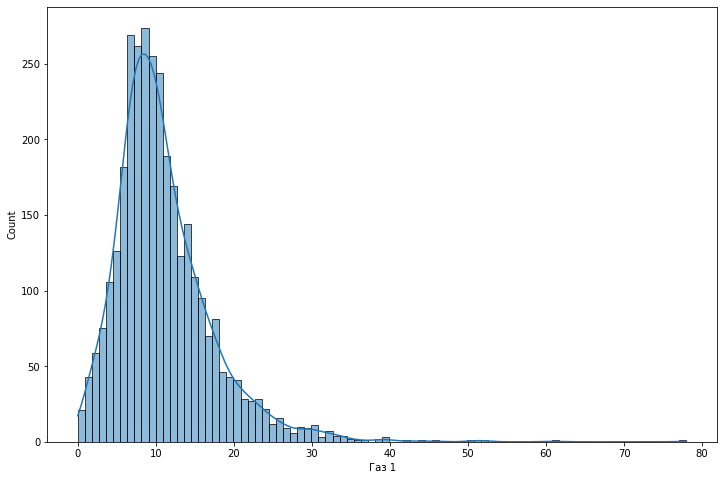

In [30]:
#consider the distribution density
plt.figure(figsize=(12,8))
sns.histplot(df_gas['Газ 1'], kde=True)
plt.show()

The distribution is normal.

### Temperature measurement results

In [31]:
df_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [32]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [33]:
print('Number of duplicates in df_temp dataset:', df_temp.duplicated().sum())

Number of duplicates in df_temp dataset: 0


This dataset has 15,907 rows and 3 columns. There are 2,906 gaps in the Temperature column. There are no duplicates.

In [34]:
#immediately cast "Sampling time" to datetime type
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')
df_temp.dtypes

key                      int64
Время замера    datetime64[ns]
Температура            float64
dtype: object

In [35]:
#look at the descriptive statistics
df_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


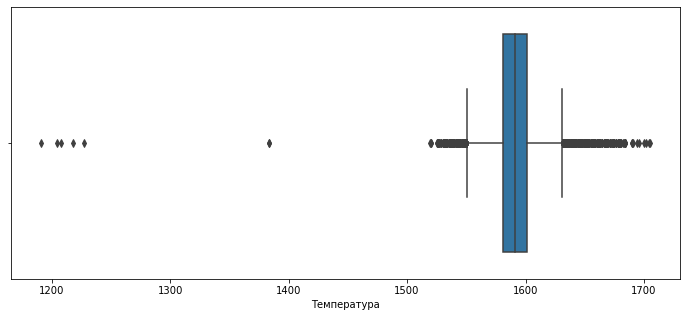

In [36]:
#build a boxplot
plt.figure(figsize=(12,5))
sns.boxplot(df_temp['Температура'])
plt.show()

There are emissions in the range up to 1400 degrees. Let's look at the distribution.

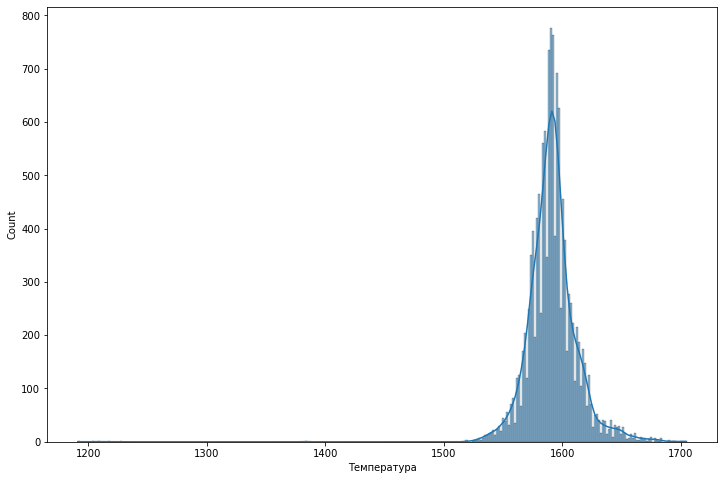

In [37]:
plt.figure(figsize=(12,8))
sns.histplot(df_temp['Температура'], kde=True)
plt.show()

The distribution is absolutely normal.

## Data preprocessing

Calculate the total power and duration of heating by graphite electrodes.

In [38]:
#add column with full power
df_arc['full_power'] = np.sqrt(df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)

#calculate the duration of heating in seconds
df_arc['heating_time'] = ((df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой'])
                          .dt.total_seconds().astype(int))

#group the data by key and create the final dataset
df_arc_final=df_arc.groupby('key').sum()[['full_power', 'heating_time']].reset_index()

#look at the resulting dataset
df_arc_final

,key,full_power,heating_time
0,1,5.826395,1098
1,2,3.649216,811
2,3,2.989534,655
3,4,3.814962,741
4,5,4.035758,869
...,...,...,...
3209,3237,4.844982,909
3210,3238,2.696542,546
3211,3239,5.611883,1216
3212,3240,3.891856,839


Now let's fill in the gaps with zeros in the df_bulk and df_wire datasets.

In [39]:
df_bulk = df_bulk.fillna(0)
df_wire = df_wire.fillna(0)

#check the result
display(df_bulk.sample(3))
display(df_wire.sample(3))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
844,880,27.0,0.0,186.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,462.0,0.0,186.0,0.0
1539,1597,0.0,0.0,131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,278.0,205.0
1630,1690,0.0,0.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157.0,0.0,141.0,104.0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2449,2576,35.075039,0.000000,0.0,0.0,0.0,45.233757,0.0,0.0,0.0
2433,2560,77.138877,3.981120,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
68,77,110.292000,45.135998,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


As we have already defined earlier, in the gas dataset, values above 34 are outliers. Let's filter the dataset and remove these 18 rows.

In [40]:
df_gas = df_gas[df_gas['Газ 1'] < 34]

In [41]:
#rename the column name in the df_gas dataset so that all columns in the final dataset are in the same style
df_gas = df_gas.rename(columns = {'Газ 1': 'gas'})
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3221 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3221 non-null   int64  
 1   gas     3221 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.5 KB


Let's move on to the final temperature dataset. It is necessary to remove emissions less than 1300 degrees from it, because. 1300 degrees is the initial melting point of steel. After that, we will remove from the dataset the parties in which there is only one measurement time, and we need at least 2, because. the start temperature is the feature and the end temperature is the target feature. You also need to highlight the initial and final temperature of one batch and the time of work with the batch.

In [42]:
#filter outliers below 1300 degrees
df_temp = df_temp.query('Температура >= 1300')

In [43]:
#group data by key and count the number of measurements
temp_count = (df_temp.groupby('key')['key'].count())\
             [(df_temp.groupby('key')['key'].count()) > 1].index

#delete indexes with one measurement from the dataset
df_temp = df_temp[df_temp['key'].isin(temp_count)]

In [44]:
#create a dataset with grouping by key and aggregating function min applied to the sampling time
start_temp = df_temp.groupby('key').agg('min')['Время замера']
start_temp = pd.DataFrame(start_temp)
start_temp = start_temp.merge(df_temp, on='Время замера', how='left')
start_temp.set_axis(['start_time', 'key', 'start_temp'], axis = 'columns', inplace = True)


#create a second dataset with grouping by key and aggregating function max applied to the sampling time
final_temp = df_temp.groupby('key').agg('max')['Время замера']
final_temp = pd.DataFrame(final_temp)
final_temp = final_temp.merge(df_temp, on='Время замера', how='left')
final_temp.set_axis(['final_time', 'key', 'final_temp'], axis = 'columns', inplace = True)

#combine the tables into a dataset
df_final_temp = start_temp.merge(final_temp, on='key', how='left')\
                  .reindex(columns=['key', 'start_time', 'start_temp', 'final_time', 'final_temp'])

#add a column with the duration of the batch
df_final_temp['duration'] = ((df_final_temp['final_time'] - df_final_temp['start_time'])
                             .dt.total_seconds().astype(int))

# leave only the required columns
df_final_temp = df_final_temp[['key', 'start_temp', 'final_temp', 'duration']]

df_final_temp

,key,start_temp,final_temp,duration
0,1,1571.0,1613.0,861
1,2,1581.0,1602.0,1305
2,3,1596.0,1599.0,1300
3,4,1601.0,1625.0,388
4,5,1576.0,1602.0,762
...,...,...,...,...
2470,2495,1570.0,1591.0,1137
2471,2496,1554.0,1591.0,1618
2472,2497,1571.0,1589.0,717
2473,2498,1591.0,1594.0,1302


In [45]:
print('Number of gaps in the dataset:', df_final_temp.isna().sum().sum())

Number of gaps in the dataset: 0


Let's merge the data for the final dataset.

In [46]:
df_final = df_final_temp.merge(df_arc_final, on='key')
df_final = df_final.merge(df_gas, on='key')
df_final = df_final.merge(df_bulk, on='key')
df_final = df_final.merge(df_wire, on='key')
display(df_final.sample(5))
df_final.info()

,key,start_temp,final_temp,duration,full_power,heating_time,gas,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
700,769,1586.0,1595.0,2304,3.351600,728,5.548130,0.0,0.0,155.0,...,205.0,222.300003,0.090480,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2240,2420,1559.0,1580.0,1135,3.723962,808,2.188564,0.0,0.0,102.0,...,0.0,85.044960,60.078716,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
111,132,1623.0,1609.0,934,1.780656,381,5.169614,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,28.108082,0.0,0.0,0.0
1313,1418,1561.0,1576.0,778,4.545594,795,14.182904,46.0,0.0,291.0,...,104.0,59.155198,40.112801,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1617,1739,1606.0,1592.0,1494,1.783217,348,14.960796,0.0,0.0,0.0,...,204.0,147.092408,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2313 entries, 0 to 2312
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2313 non-null   int64  
 1   start_temp    2313 non-null   float64
 2   final_temp    2313 non-null   float64
 3   duration      2313 non-null   int32  
 4   full_power    2313 non-null   float64
 5   heating_time  2313 non-null   int32  
 6   gas           2313 non-null   float64
 7   Bulk 1        2313 non-null   float64
 8   Bulk 2        2313 non-null   float64
 9   Bulk 3        2313 non-null   float64
 10  Bulk 4        2313 non-null   float64
 11  Bulk 5        2313 non-null   float64
 12  Bulk 6        2313 non-null   float64
 13  Bulk 7        2313 non-null   float64
 14  Bulk 8        2313 non-null   float64
 15  Bulk 9        2313 non-null   float64
 16  Bulk 10       2313 non-null   float64
 17  Bulk 11       2313 non-null   float64
 18  Bulk 12       2313 non-null 

We received the final dataset, consisting of 2313 rows and 31 columns. There are no passes.

Now let's check the correlation of features with each other, maybe some can be removed so that the model learns faster.

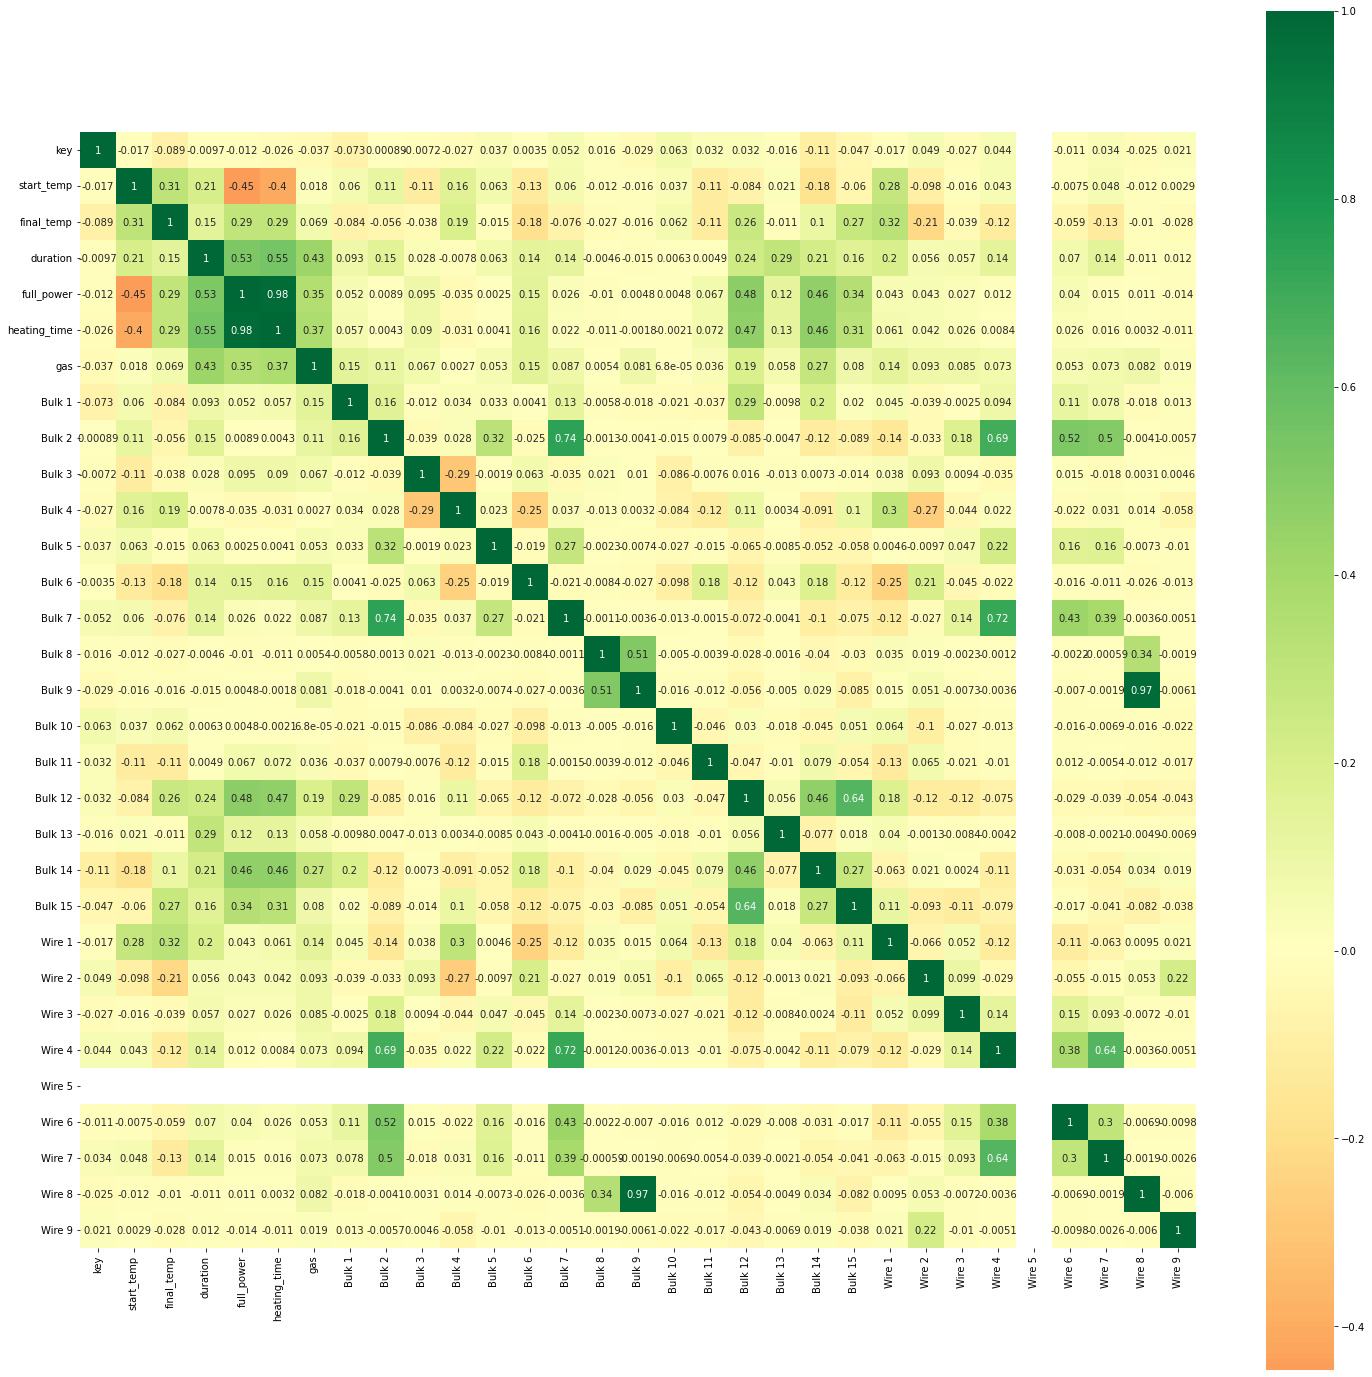

In [47]:
plt.figure(figsize=(25,25))
sns.heatmap(df_final.corr(), annot=True, cmap='RdYlGn', center=0, square=True)
plt.show()

We see that the `Wire 5` column has zero correlation everywhere. Let's see if it's empty at all.

In [48]:
df_final[df_final['Wire 5'] > 0]

,key,start_temp,final_temp,duration,full_power,heating_time,gas,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9


The `Wire 5` column does not contain any value above zero, you can delete it. We also see a correlation of 0.97 between the `Bulk 9` and `Wire 8` columns, as well as a correlation of 0.98 between the `heating_time` and `full_power` columns. Therefore, the `Wire 8` and `heating_time` columns can also be removed.

In [49]:
df_final = df_final.drop(['heating_time', 'Wire 5', 'Wire 8'], axis=1)

Our dataset is ready for model training.

### Section Conclusion:
1. Columns with `total power` and `heating duration` have been added to the df_arc dataset.
2. In the df_bulk and df_wire datasets, all gaps were replaced with zeros, because omission means that these additives were not used at a particular stage of heating.
3. In the df_gas dataset, outliers with a value greater than 34 have been removed.
4. In the df_temp dataset, outliers below 1300 degrees were removed, because is the minimum melting point of steel. Keys with only one measurement time were also filtered out. Also, the initial and final temperature of the alloy in one batch was determined, where the final temperature will be the target feature.
5. All processed datasets were merged into one df_final dataset by the `key` key. It turned out 2313 rows and 30 columns.
6. For the final dataset, a heatmap with feature correlation was built. As a result, the `Wire 5` column was removed from the dataset, because it turned out to be empty without a single value, the `Wire 8` column, because it had a correlation with the `Bulk 9` column of 0.97 and the `heating_time` column, as it had a correlation from the `full_power` columns of 0.98.

## Model Training

We will train 4 models: linear regression, random forest, Catboost and LightGBM.

In [50]:
#separate signs
features = df_final.drop(['key', 'final_temp'], axis=1)
target = df_final['final_temp']

print('Dataset size with features:', features.shape)
print('Dataset size with target feature:', target.shape)

Dataset size with features: (2313, 26)
Dataset size with target feature: (2313,)


In [51]:
#select the training and test sets in a ratio of 3:1
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=20220809)
print('Training sample size:', len(target_train))
print('Test sample size:', len(target_test))

Training sample size: 1734
Test sample size: 579


### Linear regression

First, we will train linear regression.

In [52]:
linear_model = LinearRegression(n_jobs=-1)
linear_model.fit(features_train, target_train)
linear_score = cross_val_score(linear_model, features_train, target_train,
                               cv=5, scoring='neg_mean_absolute_error').mean()
 
print('MAE of linear regression on the training set:', abs(linear_score))

MAE of linear regression on the training set: 5.891506941288741


With cross-validation, already on linear regression, we got an excellent result MAE 5.89.

### Random forest

In [53]:
%%time

forest_model = RandomForestRegressor(random_state=20220809)
forest_params = {'n_estimators':range(50, 500, 50), 'max_depth':range(10, 50, 5)}
forest_grid = GridSearchCV(forest_model, forest_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
forest_grid.fit(features_train, target_train)
forest_score = cross_val_score(forest_grid, features_train, target_train,
                               cv=5, scoring='neg_mean_absolute_error').mean()

print('Best Random Forest Options:', forest_grid.best_params_)
print('MAE of the random forest on the training set:', abs(forest_score))

Best Random Forest Options: {'max_depth': 25, 'n_estimators': 400}
MAE of the random forest on the training set: 5.921362280958269
CPU times: total: 19.8 s
Wall time: 6min 38s


Random forest has a slightly worse MAE metric than linear regression and is equal to 5.92.

### Catboost

In [54]:
%%time

cat_model = CatBoostRegressor(iterations=100, verbose=False, random_state=20220809)
cat_params = {'learning_rate':[0.01, 0.05, 0.1], 'depth':range(5, 15, 2)}
cat_grid = GridSearchCV(cat_model, cat_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
cat_grid.fit(features_train, target_train)
cat_score = cross_val_score(cat_grid, features_train, target_train,
                               cv=5, scoring='neg_mean_absolute_error').mean()

print('Best Catboost Options:', cat_grid.best_params_)
print('MAE Catboost on training set:', abs(cat_score))

Best Catboost Options: {'depth': 7, 'learning_rate': 0.1}
MAE Catboost on training set: 5.771511321025834
CPU times: total: 12.5 s
Wall time: 15min 6s


Catboost showed the result even better than the previous models - 5.77.

### LightGBM

In [55]:
%%time

gbm_model = LGBMRegressor(random_state=20220809)
gbm_params = {'n_estimators':range(50, 500, 50), 'num_leaves':range(10, 20, 2)}
gbm_grid = GridSearchCV(gbm_model, gbm_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
gbm_grid.fit(features_train, target_train)
gbm_score = cross_val_score(gbm_grid, features_train, target_train,
                               cv=5, scoring='neg_mean_absolute_error').mean()

print('Best LightGBM Options:', gbm_grid.best_params_)
print('MAE LightGBM on the training set:', abs(gbm_score))

Best LightGBM Options: {'n_estimators': 100, 'num_leaves': 18}
MAE LightGBM on the training set: 5.747921134654371
CPU times: total: 8 s
Wall time: 19.6 s


LightGBM showed the best MAE result among the four models - 5.74, while it is also faster than Catboost and random forest.

To check on the test sample, let's focus on LightGBM.

Let's create a pivot table with the results of the models.

In [56]:
data={'Model': ['Linear Regression', 'RandomForest', 'CatBoost', 'LightGBM'],
      'MAE': [5.89, 5.92, 5.77, 5.74]}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

,Model,MAE
0,Linear Regression,5.89
1,RandomForest,5.92
2,CatBoost,5.77
3,LightGBM,5.74


### Model testing

In [57]:
gbm_test_model = gbm_grid.best_estimator_
gbm_test_model.fit(features_train, target_train)
gbm_predictions = gbm_test_model.predict(features_test)
print('MAE LightGBM on the test set is:', mae(target_test, gbm_predictions))

MAE LightGBM on the test set is: 5.532867650633162


We got an excellent MAE result on the test sample equal to 5.53. To check the adequacy of the model, we compare the result with the Dummy model.

In [58]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train, target_train)
dummy_predictions = dummy.predict(features_test)
print('The MAE Dummy of the model on the test set is:', mae(target_test, dummy_predictions))

The MAE Dummy of the model on the test set is: 7.74702137280799


The dummy model demonstrated MAE at 7.74. The result is worse than all our models.

Let's look at the feature importance histogram.

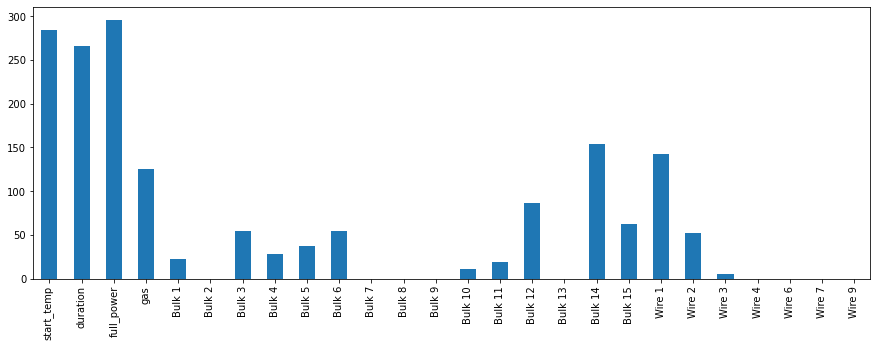

In [59]:
importances = pd.Series(gbm_test_model.feature_importances_, index=features_train.columns)

plt.figure(figsize=(15,5))
importances.plot.bar()
plt.show()

The most important features during training turned out to be: `start_temp`, `duration` and `full_power`, which were prepared and highlighted by us ourselves.

### Section Conclusion:

1. 4 models were trained: Linear Regression, Catboost Random Forest and LightGBM. The best MAE metric was achieved by LightGBM at 5.74, followed by Catboost at 5.77. As a result, it was decided to test LightGBM on a test sample.
2. On the test sample, LightGBM achieved an excellent MAE result of 5.53.
3. Based on the histogram of the importance of features, the most important features during training turned out to be: start_temp, duration and full_power, which were prepared and selected by us independently.

## General Conclusion:

1. ***7 datasets were uploaded and studied:***
    - `data_arc` - data about electrodes;
    - `data_bulk` - data on the supply of bulk materials (volume);
    - `data_bulk_time` - data on the supply of bulk materials (time);
    - `data_gas` — data on alloy gas purge;
    - `data_temp` - temperature measurement results;
    - `data_wire` - data on wire materials (volume);
    - `data_wire_time` - wire materials data (time).

The `data_arc` dataset has 5 columns and 14,876 rows. There are no gaps or duplicates. The columns "Start of arc heating" and "End of arc heating" have been converted to the datetime type. An outlier equal to -715.504924 was found in the `reactive power` column and was removed. The distribution in the dataset is generally normal, skewed to the right.<br>
The `data_bulk` and `data_bulk_time` datasets have 3129 rows and 16 columns. There are no duplicates. There are a lot of gaps in the data, because these impurities were not added to every alloy and not every time, but only if necessary to change the composition.<br>
Datasets `data_wire` and `data_wire_time` have 3081 rows and 10 columns. There are no duplicates. Here we see exactly the same picture as in the previous `bulk` datasets: a lot of gaps for the same reason.<br>
The `data_gas` dataset has 3239 rows and only 2 columns. There are no gaps or duplicates. All values ​​above 34 were determined to be outliers.
The `data_temp` dataset has 15,907 rows and 3 columns. There are 2,906 gaps in the Temperature column. There are no duplicates. The column "Sampling time" has been converted to datetime type. Outliers were found in the dataset. The distribution is absolutely normal.

2. ***When preprocessing data:***
    1. Columns with `total power` and `heating time` have been added to the df_arc dataset.
    2. In the df_bulk and df_wire datasets, all gaps were replaced with zeros, because omission means that these additives were not used at a particular stage of heating.
    3. In the df_gas dataset, outliers with a value greater than 34 have been removed.
    4. In the df_temp dataset, outliers below 1300 degrees were removed, because is the minimum melting point of steel. Keys with only one sampling time were also filtered out. The initial and final temperature of the alloy in one batch was determined, where the final temperature will be the target feature.
    5. All processed datasets were combined into one dataset `df_final` by the key `key`. It turned out 2313 rows and 31 columns.
    6. Datasets `data_bulk_time` and `data_wire_time` were not used in the formation of the final dataset.
    7. For the final dataset, a heatmap with feature correlation was built. As a result, the `Wire 5` column was removed from the dataset, because it turned out to be empty without a single value, the `Wire 8` column, because it had a correlation with the `Bulk 9` column of 0.97 and the `heating_time` column, as it had a correlation from the `full_power` columns of 0.98.
    
3. ***Model training:***
    1. 4 models were trained: Linear Regression, Catboost Random Forest and LightGBM. The best MAE metric was achieved by LightGBM at 5.74, followed by Catboost at 5.77. As a result, it was decided to test LightGBM on a test sample.
    2. **LightGBM achieved an excellent MAE score of 5.53 on the test set.**
    3. Based on the histogram of the importance of features, the most important features during training turned out to be: start_temp, duration and full_power, which were prepared and selected by us independently.

4. ***Recommendations for the customer to save energy resources:***
    1. Judging by the model, the most important factor is the initial temperature. This means that by managing it, we will be able to manage energy costs. Now we need to develop measures for this solution. And here the question arises: is it possible to control the initial temperature and what needs to be done for this?
    2. We have a variation in measurements. Then the problem can be formulated as follows: it is necessary to reduce the spread in measurements, and in this case in temperature. One of the approaches is this: there are certainly boundaries within which temperature fluctuations are normal. I propose to fix cases when the temperature goes beyond these limits, say, mark it as "1". And then for such moments of time to collect information on production: what was the material (chemistry of the material), what was the gas (chemical composition of the gas), which team worked, what happened with the electrodes, and other points related to the knowledge of the process production. And here we can find real reasons (through correlations, hypothesis testing, different models), fix these reasons and, based on this, develop more effective energy-saving measures.